In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import applications

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def load_results(directory_path, filename):
    with open(directory_path + filename + '.txt') as json_file:
        data = pd.DataFrame(json.load(json_file))
    return(data)

# Preprocessing :

Dans cette partie plusieurs approches de preprocessing des images ont été testées afin de valider leur intérêt.
On testera leur impact en utilisant le modèle CNN basique suivant :

- Une couche de convolution à 16 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 32 filtres de taille 3x3, activation 'relu'
- Une couche 'flatten'
- Une couche fully connected à 250 neurones, activation 'relu' et dropout
- Une couche de prédiction à 120 neurones, activation 'softmax'

Chaque couche de convolution est suivie d'une couche de max pooling avec un kernel de 2x2.
La fonction de perte utilisée est 'catégorical_cross_entropy' et l'indicateur de performance est la précicion.

On teste le modèle dans 3 conditions :

- A partir des images brutes
- A partir d'images 'cropped', où l'on a conservé uniquement les zones où sont présent les chiens
- A partir d'images 'cropped' augmentées à base de petites rotations, translations et zoom.

Text(0.5, 1.1, 'Impact preprocessing')

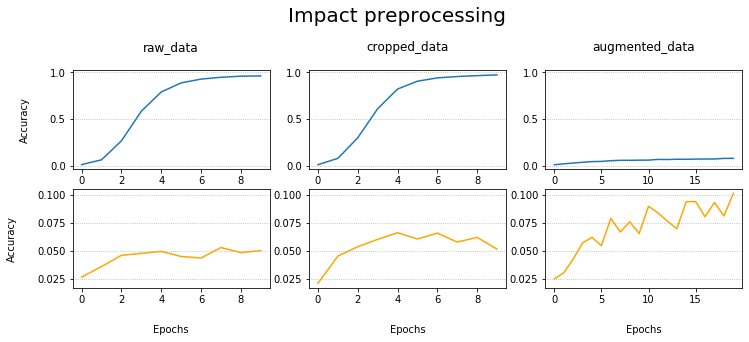

In [4]:
directory_path = 'resultats/comparaison_preprocessing/'

base_results = load_results(directory_path, 'test_data_base')
crop_results = load_results(directory_path, 'test_data_cropping')
aug_results = load_results(directory_path, 'test_data_augment')

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, clear=True, figsize=(12,4))

ax0.get_shared_y_axes().join(ax0, ax1, ax2)

ax0.plot('accuracy', data=base_results)
ax1.plot('accuracy', data=crop_results)
ax2.plot('accuracy', data=aug_results)

ax3.get_shared_y_axes().join(ax3, ax4, ax5)

ax3.plot('val_accuracy', data=base_results, color='orange')
ax4.plot('val_accuracy', data=crop_results, color='orange')
ax5.plot('val_accuracy', data=aug_results, color='orange')

ax0.set_title('raw_data', pad=20)
ax1.set_title('cropped_data', pad=20)
ax2.set_title('augmented_data', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)
ax3.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax3.set_xlabel(xlabel='Epochs', labelpad = 20)
ax4.set_xlabel(xlabel='Epochs', labelpad = 20)
ax5.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')
ax3.yaxis.grid(True, linestyle=':')
ax4.yaxis.grid(True, linestyle=':')
ax5.yaxis.grid(True, linestyle=':')

fig.suptitle('Impact preprocessing', y=1.1, fontsize=20)

A partir de ce premier test, on peut conclure que :  

- Le modèle issu des données brutes donne les moins bon résultats (environ 5% de précision)
- Le modèle déterminé à partir des images 'cropped' donne de meilleurs résultats (environ 7% de précision)  

Dans ces deux cas le modèle overfit énormément, sans surprise vu le peu de données disponibles.
Le modèle issu des données augmentées lui n'overfit plus car beaucoup plus d'images sont disponibles, les performances sont également rapidement augmentées en quelques époques de plus( 10% de précision au bout de 20 époques). C'est l'approche qui sera retenue pour la suite.

# Modèle custom basé sur VGG

Dans cette partie on part du modèle présenté à la partie précédente et on lui apportera quelques modifications structurelles afin d'étudier leur impact. Les modifications testées sont les suivantes :
- Ajout de couches de convolutions (1) :

On ajoute à la suite des couches de convolutions et avant les couches flatten et fully connected deux couches de convolutions, une à 64 filtres et une à 128. La taille des filtres reste la même et la max pooling est également appliqué.

- Augmentation du nombre de filtres par couche de convolution (2) :

On part du modèle avec l'augmentation du nombre de couches de convolution (1) et l'on multiplie le nombre de filtres au sein de chaque couche par 2. Les couches de convolutions ont donc dans l'ordre 32, 64, 128 et 256 filtres.

- Augmentation de la taille des filtres (3) :

On part du modèle avec l'augmentation du nombre de couches de convolution (1) et l'on change la taille de certain filtres, pour avoir des filtres plus 'grossier' au départ et plus 'fin' plus on avance dans les couches. Les filtres ont, dans l'ordre, une taile de 7x7, 5x5, 5x5 et 3x3.

## Impact de la structure

Text(0.5, 1.1, 'Impact structure')

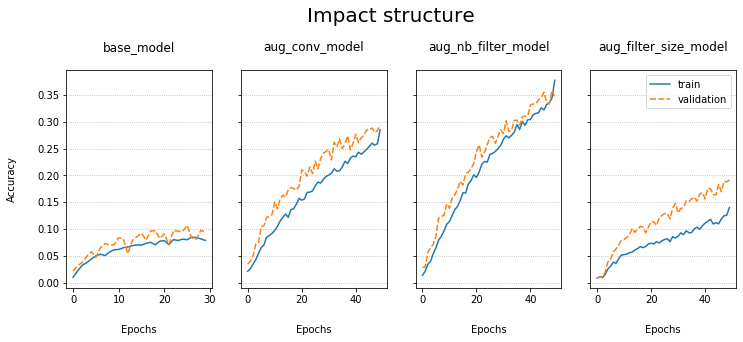

In [5]:
directory_path = 'resultats/impact_structure_custom_VGG/'

base_results = load_results(directory_path, 'base_model_hist')
aug_conv_results = load_results(directory_path, 'aug_conv_model_hist')
aug_filter_nb_results = load_results(directory_path, 'aug_nb_filter_model_hist')
aug_filter_size_results = load_results(directory_path, 'aug_filter_size_model_hist')

fig, (ax0, ax1, ax2,ax3) = plt.subplots(1,4, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=base_results.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=aug_conv_results.loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=aug_filter_nb_results.loc[:,['accuracy','val_accuracy']], ax=ax2, legend=None)
sns.lineplot(data=aug_filter_size_results.loc[:,['accuracy','val_accuracy']], ax=ax3)

ax0.set_title('base_model', pad=20)
ax1.set_title('aug_conv_model', pad=20)
ax2.set_title('aug_nb_filter_model', pad=20)
ax3.set_title('aug_filter_size_model', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)
ax3.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')
ax3.yaxis.grid(True, linestyle=':')

ax3.legend(labels=['train', 'validation'])

fig.suptitle('Impact structure', y=1.1, fontsize=20)

On constate que l'ajout de couches de convolution et l'augmentation du nombre de filtres permet d'augmenter fortement les performances. On passe ainsi de 8/10% à environ 30% de précision en ajoutant les couches de convolutions et à 35% en doublant ensuite le nombre de filtres. L'augmentation de la taille des filtres ne semble pas très pertinente, ralentissant fortement l'apprentissage et avec un écart train / validation important.

## Optimisation du modèle final

Suite aux observations réalisées lors des parties précédentes, on défini un modèle 'final' comme suit, que l'on cherche à optimiser :

- Une couche de convolution à 32 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 32 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 64 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 64 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 128 filtres de taille 3x3, activation 'relu'
- Une couche de convolution à 256 filtres de taille 3x3, activation 'relu'
- Une couche 'flatten'
- Une couche fully connected à 500 neurones, activation 'relu' et dropout
- Une couche fully connected à 250 neurones, activation 'relu'et dropout
- Une couche de prédiction à 120 neurones, activation 'softmax'

Chaque couche de convolution est suivie d'une couche de pooling Max avec un kernel de 2x2.
La fonction de perte utilisée est 'catégorical_cross_entropy' et l'indicateur de performance est la précicion.


### Impact régularisation

Le niveau de régularisation du modèle, impacté par l'hyperparamètre des couches de dropout peut être ajusté en le faisant varier. Les couches de dropout permettent de ne pas prendre en compte la sortie d'un neurone lors du passage de l'information d'une couche à l'autre, créant des modèles plus simples et donc se généralisant souvent mieux. Le paramètre passé à la couche dropout correspond à la probabilté pour chaque neurone de la couche la précédent qu'il ne soit pas pris en compte.  
  
Par exemple prenons le cas de la couche dropout avec une valeur de paramètre de 0.5 entre la couche de prédiction à 120 neurones et la couche la précédent à 250 neurones. Cette valeur de 0.5 signifie que lors du passage de l'information des 250 neurones au 120 suivants, chacun des 250 neurones a une probabilté de 50% de ne pas être pris en compte.  
  
Intuitivement cela ressemble aux fôrets aléatoires, où à chaque batch de données un modèle 'faible' est créé et leur combinaison dans le modèle final donne un résultat plus intéressant.

Text(0.5, 1.1, 'Impact dropout')

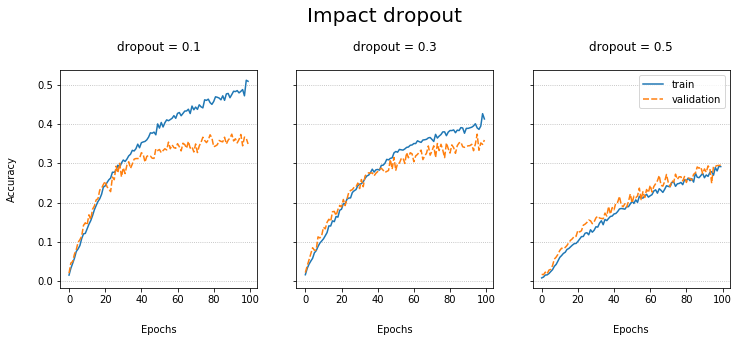

In [6]:
directory_path = 'resultats/impact_dropout_custom_VGG/'

results_low_dropout = load_results(directory_path, 'final_model_1')
results_medium_dropout = load_results(directory_path, 'final_model_3')
results_high_dropout = load_results(directory_path, 'final_model_5')

fig, (ax0, ax1, ax2) = plt.subplots(1,3, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=results_low_dropout.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_medium_dropout.loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_high_dropout.loc[:,['accuracy','val_accuracy']], ax=ax2)


ax0.set_title('dropout = 0.1', pad=20)
ax1.set_title('dropout = 0.3', pad=20)
ax2.set_title('dropout = 0.5', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')

ax2.legend(labels=['train', 'validation'])

fig.suptitle('Impact dropout', y=1.1, fontsize=20)

Pour ce modèle, la valeur de dropout de 0.3 semble intéressante, convergeant assez rapidement avec un léger overfitting. Avec une valeur de dropout de 0.1 le modèle converge plus rapidement sur le set de validation mais l'overfitting est important. La valeur de dropout de 0.5 semble également intéressante, mais freine l'entrainement. On retiendra la valeur de dropout de 0.3 qui semble être un bon compromis entre overfitting et vitesse d'apprentissage.

### Impact optimizer

Dans cette partie on cherchera à utiliser différentes méthodes d'optimisation pour le calcul de la backpropation du gradient et donc la convergence du modèle. Le niveau de dropout est de 0.3.

Text(0.5, 1.1, 'Impact optimizer')

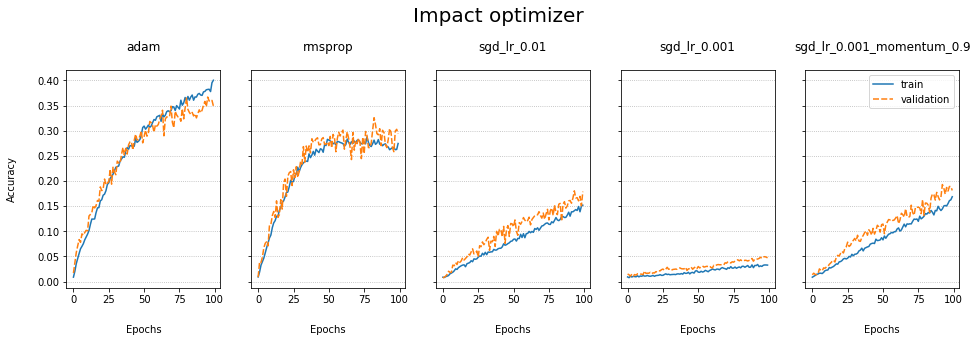

In [7]:
directory_path = 'resultats/impact_optimizer_custom_VGG/'

results_adam = load_results(directory_path, 'final_model_adam')
results_rmsprop = load_results(directory_path, 'final_model_rmsprop')
results_sgd_high = load_results(directory_path, 'final_model_sgd_high')
results_sgd_low = load_results(directory_path, 'final_model_sgd_low')
results_sgd_momentum = load_results(directory_path, 'final_model_sgd_momentum')

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, clear=True, sharey=True, figsize=(16,4))

sns.lineplot(data=results_adam.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_rmsprop.loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_sgd_high.loc[:,['accuracy','val_accuracy']], ax=ax2, legend=None)
sns.lineplot(data=results_sgd_low.loc[:,['accuracy','val_accuracy']], ax=ax3, legend=None)
sns.lineplot(data=results_sgd_momentum.loc[:,['accuracy','val_accuracy']], ax=ax4)

ax0.set_title('adam', pad=20)
ax1.set_title('rmsprop', pad=20)
ax2.set_title('sgd_lr_0.01', pad=20)
ax3.set_title('sgd_lr_0.001', pad=20)
ax4.set_title('sgd_lr_0.001_momentum_0.9', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)
ax3.set_xlabel(xlabel='Epochs', labelpad = 20)
ax4.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')
ax3.yaxis.grid(True, linestyle=':')
ax4.yaxis.grid(True, linestyle=':')

ax4.legend(labels=['train', 'validation'])

fig.suptitle('Impact optimizer', y=1.1, fontsize=20)

Le modèle utilisant l'optimizer 'Adam' donne les meilleurs résultats, avec une performances aux alentours de 35% sur le set de validation.
Celui utilisant 'rmsprop' converge lui plus vite, mais vers une performance plus faible (28%)
Les modèles utilisant 'SGD', quel que soit le learning rate, progresse de manière linéaire et beaucoup plus lente. Il est possible qu'une augmentation du learning permette d'atteindre une performance intéressante  néanmoins les algorithmes adaptatifs donne déjà de bon résultats, et ce rapidement.

# Modèle custom base ResNet

Une autre structure de modèle a également été testée, basée sur l'architecture ResNet et notamment le bloc de convolution résiduel. Le bloc de convolution résiduel est un ensemble de plusieurs couches de convolutions, auquelles on ajoute aux valeurs de sortie celles en entrée du bloc, issues du bloc précédent. L'addition des deux matrices nécessitant qu'elles aient les mêmes dimensions, si le bloc précédent possèdent un nombre de filtres différent les données d'entrées passent par un bloc de convolution avec des filtres 1x1 supplémentaires avant leur addition.
Le bloc de convolution résiduel pour ce cas a été défini comme tel :

- Une couche de convolution optionnelle, avec 'n' filtres de 1x1, un stride de 's', un padding 'same' et une fonction d'activation 'relu', permettant d'adapter les dimensions si le nombre de filtres de ce bloc est différent du précédent.
- Une couche de convolution, avec 'n' filtres de 3x3, un stride de 1, un padding 'same' et une fonction d'activation 'relu'
- Une couche de convolution, avec 'n' filtres de 3x3, un stride de 's', un padding 'same' et sans activation
- une sortie composée de la somme de l'entrée et de la sortie de la dernière couche de convolution sans activation. Somme à laquelle on applique ensuite une fonction d'activation 'relu'

## Modèle

Le modèle est composée de la manière suivante :

- Une couche d'entrée 224x224x3
- Une couche de convolution avec 16 filtres de 7x7, des strides de 2, un padding 'same' et une activation 'relu'
- Un bloc résiduel avec 32 filtres et des strides de 2
- 2 blocs résiduels avec 32 filtres et des strides de 1
- Un bloc résiduel avec 64 filtres et des strides de 2
- 2 blocs résiduels avec 64 filtres et des strides de 1
- Un bloc résiduel avec 128 filtres et des strides de 2
- Un bloc résiduel avec 256 filtres et des strides de 2
- Une couche d'average pooling avec une fenêtre de 2x2
- Une couche 'flatten'
- Une couche fully connected à 250 neurones, activation 'relu'
- Une couche de prédiction à 120 neurones, activation 'softmax'

Les strides de 2 permettent de réduire les deux premières dimensions lors de l'augmentation de la troisième avec l'augmentation du nombre de filtres.


## Régularisation L2

Lors d'essais préliminaires il a été constaté que le modèle a une forte tendance au sur-apprentissage. On teste dans un premier temps une régularisation L2 au sein des couches de convolutions

Text(0.5, 1.1, 'Impact regularisation L2 custom ResNet')

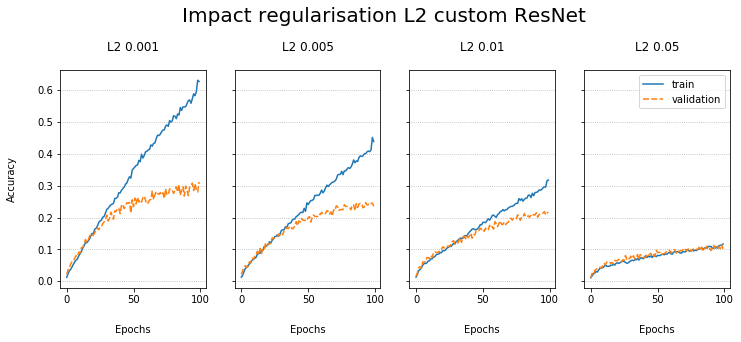

In [8]:
directory_path = 'resultats/custom_resnet/'

results_L2_0_001 = load_results(directory_path, 'final_res_model_L2_1')
results_L2_0_005 = load_results(directory_path, 'final_res_model_L2_5')
results_L2_0_01 = load_results(directory_path, 'final_res_model_L2_10')
results_L2_0_05 = load_results(directory_path, 'final_res_model_L2_50')

fig, (ax0, ax1, ax2,ax3) = plt.subplots(1,4, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=results_L2_0_001.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_L2_0_005.loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_L2_0_01.loc[:,['accuracy','val_accuracy']], ax=ax2, legend=None)
sns.lineplot(data=results_L2_0_05.loc[:,['accuracy','val_accuracy']], ax=ax3)

ax0.set_title('L2 0.001', pad=20)
ax1.set_title('L2 0.005', pad=20)
ax2.set_title('L2 0.01', pad=20)
ax3.set_title('L2 0.05', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)
ax3.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')
ax3.yaxis.grid(True, linestyle=':')

ax3.legend(labels=['train', 'validation'])

fig.suptitle('Impact regularisation L2 custom ResNet', y=1.1, fontsize=20)

Au final, afin de clairement limiter le sur-apprentissage il est nécessaire d'imposer une forte régularisation (coefficient de 0.05), néanmmoins cela ralentit drastiquement l'apprentissage et la performance finale (10% de précision). La régularisation via la norme L2 ne semble pas être une bonne option.

## Réglarisation dropout

Dans cette partie, une autre option de régularisaiton a été testée, en ajoutant du dropout en sortie de la couche du classifieur à 250 neurones.

Text(0.5, 1.1, 'Impact regularisation Dropout custom ResNet')

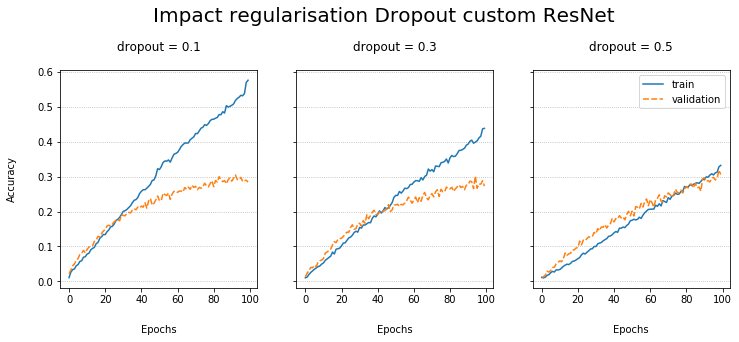

In [9]:
directory_path = 'resultats/custom_resnet/'

results_dropout_0_1 = load_results(directory_path, 'final_res_model_dropout_1')
results_dropout_0_3 = load_results(directory_path, 'final_res_model_dropout_3')
results_dropout_0_5 = load_results(directory_path, 'final_res_model_dropout_5')

fig, (ax0, ax1, ax2) = plt.subplots(1,3, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=results_dropout_0_1.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_dropout_0_3.loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_dropout_0_5.loc[:,['accuracy','val_accuracy']], ax=ax2)

ax0.set_title('dropout = 0.1', pad=20)
ax1.set_title('dropout = 0.3', pad=20)
ax2.set_title('dropout = 0.5', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')

ax2.legend(labels=['train', 'validation'])

fig.suptitle('Impact regularisation Dropout custom ResNet', y=1.1, fontsize=20)

On voit qu'il faut également que la valeur de régularisation soit relativement élevée (0.5) afin de limiter le sur-apprentissage. Cela réduit fortement la vitesse d'apprentissage également, néanmoins d'un point de vue performances celles ci sont bien meilleures (environ 30% de précision). Laisser l'apprentissage se poursuivre pendant une cinquantaine d'époques supplémentaires aurait pu être intéressant pour voir si le modèle continuait de progresser sans sur-apprentissage. La courbe laisse tout de même à penser que l'overfitting commence à se faire sentir.

# Transfer Learning

Dans cette partie seront présentés les résultats obtenus par transfer learning, c.a.d l'utilisation d'un modèle entrainé au préalable sur une très grande collection d'image. Le but est ici d'exploiter ce qui a pu être appris par ces modèles et de l'adapter pour notre besoin. Pour cela deux options possibles :
- On utilise les modèles pré établis comme 'extracteurs de features' et l'on entraine un nouveau classifieur sur ces nouvelles features pour prédire les classes souhaitées.  
  
- On combine les modèles prétablis et les classifieurs obtenus à l'étape précédente pour créer un nouveau modèle. On fige une bonne partie des premières couches permettant l'extraction de features et l'on laisse au reste du modèle la possibilité de s'adapter aux nouvelles données. On conserve ainsi les features génériques des couches basses du modèle utilisées pour le transfer learning, tout en se permetttant de générer pour le reste du modèle des features plus spécifiques et adaptées à notre problématique. Cela se nomme le 'tunning' partiel.

## Features extraction :

Pour cette partie, le processus suivi est le suivant :

- On charge le modèle pré entrainé de notre choix, sans les couches hautes servant à la classification
- On l'utilise en mode 'inférence' sur nos données d'entrainement et de validation afin de créer deux nouveaux sets de données. Ce sont de nouvelles 'features', extraites de nos données correspondant à la sortie du modèle pré entrainé sans ses couches hautes.
- On créé un nouveau classifieur qui prend en entrée les nouvelles données établies à l'étape précédente.
- On entraine ce classifieur.

Cela nous permet d'établir très rapidement des modèles performants, rapides à entrainer. Cette méthode fonctionne car des images de chiens ont déjà été utlisées lors de l'entrainement préalable des modèles utilisés comme base pour le transfer learning.

A la fin on sauvegarde les poids associés au classifieur afin de pouvoir les réutiliser ultérieurement.

Text(0.5, 1.1, 'TL features extraction + classifier')

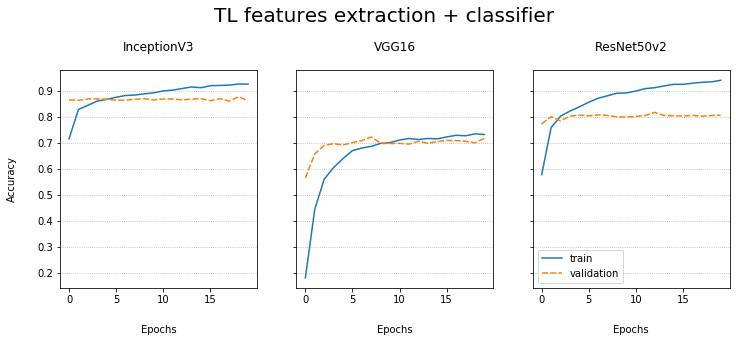

In [73]:
directory_path = 'resultats/transfer_learning/'

results_inception = load_results(directory_path, 'trl_top_inception')
results_vgg16 = load_results(directory_path, 'trl_top_VGG')
results_resnet50 = load_results(directory_path, 'trl_top_resnet50')

fig, (ax0, ax1, ax2) = plt.subplots(1,3, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=results_inception.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_vgg16 .loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_resnet50.loc[:,['accuracy','val_accuracy']], ax=ax2)

ax0.set_title('InceptionV3', pad=20)
ax1.set_title('VGG16', pad=20)
ax2.set_title('ResNet50v2', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')

ax2.legend(labels=['train', 'validation'])

fig.suptitle('TL features extraction + classifier', y=1.1, fontsize=20)

Les performances obtenues sont bien meilleures que pour les modèles 'custom' :
- Inception V3 : 87% de précision sur le set de validation
- VGG16 : 70% de précision sur le set de validation
- ResNetV2 : 80% de précision sur le set de validation

Néanmmoins on voit que malgré l'entrainement, la performance sur le set de validation n'évolue quasiment pas à partir de 2/3 époques.

## Fine tuning partiel

Pour le fine tuning partiel la procédure est un peu différente, puisque cette fois ci le modèle pré entrainé ne fonctionnera pas complétement en mode 'inférence' car l'on autorisera certaines de ses couches à s'entrainer.
La procédure est la suivante :

- chargement du modèle pré-entrainé
- On fige une partie des couches basses de ce modèle
- On lui ajoute à la suite le classifieur établit à la partie précédente
- On initialise le classifieur avec les poids sauvegardés. Cette étape est importante car une initialisation aléatoire des couches de sortie pourrait casser la dynamique de propagation du gradient avec des écarts de valeurs trop importants.
- On entraine le nouveau modèle obtenu.

Text(0.5, 1.1, 'TL partial tuning')

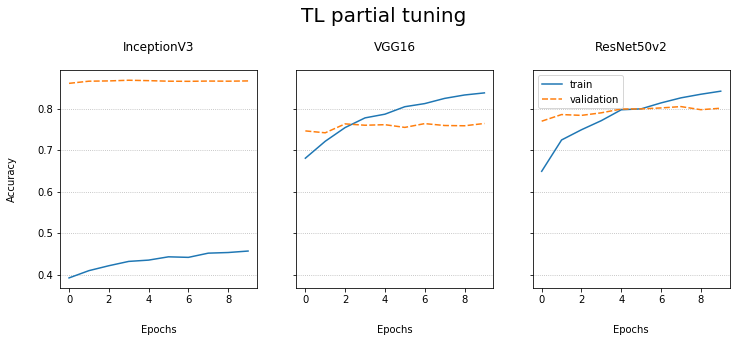

In [72]:
directory_path = 'resultats/transfer_learning/'

results_tuning_inception = load_results(directory_path, 'trl_partial_tuning_inception')
results_tuning_vgg16 = load_results(directory_path, 'trl_partial_tuning_VGG')
results_tuning_resnet50 = load_results(directory_path, 'trl_partial_tuning_resnet')

fig, (ax0, ax1, ax2) = plt.subplots(1,3, clear=True, sharey=True, figsize=(12,4))

sns.lineplot(data=results_tuning_inception.loc[:,['accuracy','val_accuracy']], ax=ax0, legend=None)
sns.lineplot(data=results_tuning_vgg16 .loc[:,['accuracy','val_accuracy']], ax=ax1, legend=None)
sns.lineplot(data=results_tuning_resnet50.loc[:,['accuracy','val_accuracy']], ax=ax2)

ax0.set_title('InceptionV3', pad=20)
ax1.set_title('VGG16', pad=20)
ax2.set_title('ResNet50v2', pad=20)

ax0.set_ylabel(ylabel='Accuracy', labelpad = 20)

ax0.set_xlabel(xlabel='Epochs', labelpad = 20)
ax1.set_xlabel(xlabel='Epochs', labelpad = 20)
ax2.set_xlabel(xlabel='Epochs', labelpad = 20)

ax0.yaxis.grid(True, linestyle=':')
ax1.yaxis.grid(True, linestyle=':')
ax2.yaxis.grid(True, linestyle=':')

ax2.legend(labels=['train', 'validation'])

fig.suptitle('TL partial tuning', y=1.1, fontsize=20)

Au final, le tuning partiel n'a permis d'augmenter les performances uniquement du modèle basé sur le VGG16, avec un gain de 5%. On constate qu'il existe une grande différence de performances entre le set d'entrainement et celui de validation pour l'InceptionV3. Cela s'explique peut être par la différence de fonctionnement de certaines couches du modèle selon son mode de fonctionnement : inférence ou entrainement ([voir lien](https://github.com/keras-team/keras/pull/9965)).

# Modèles retenus :

Après ces différentes modélisations, on peut retenir deux modèles, correspondant à chacune des deux approches : création d'un CNN custom ou bien transfer learning.

- Pour le CNN custom, on retiendra le modèle obtenu au 2.2, avec un niveau de dropout en sortie de 0.3 et l'optimizer 'adam'. Celui ci a une performance de 35% sur le set de validation (la meilleure) et ne sur-apprend pas.  
- Pour l'approche transfer learning, on retiendra le modèle basé sur l'InceptionV3. On utilisera ce dernier pour l'extraction de features qui seront ensuite fournies au classifieur. Cela permet d'obtenir la meilleure des performances tous modèles confondus, avec 87% de précision sur le set de validation.

# Performances sur le set de test :

Dans cette partie on testera les deux modèles retenus sur le set de test.

In [4]:
directory_path = 'C:/Users/Antoine/Documents/Git/Projet 6/'

In [69]:
datagen_tl = ImageDataGenerator(preprocessing_function=applications.inception_v3.preprocess_input)
test_it_tl = datagen_tl.flow_from_directory(directory_path + 'data_keras/data_cropped/test/', 
                                      class_mode='categorical', batch_size=1, target_size=(224, 224), shuffle=False)

Found 3099 images belonging to 120 classes.


In [54]:
datagen_custom = ImageDataGenerator(rescale=1/255)
test_it_custom = datagen_custom.flow_from_directory(directory_path + 'data_keras/data_cropped/test/', 
                                      class_mode='categorical', batch_size=1, target_size=(224, 224), shuffle=False)

Found 3099 images belonging to 120 classes.


In [35]:
labels=pd.read_csv('data_keras/labels/dog_breed_mapping.csv', index_col='key')

In [12]:
true_labels = np.load(open('data_keras/labels/bottleneck_labels_test.npy', 'rb'))

## Custom model

In [52]:
custom_model = load_model('resultats/modeles_retenus/final_model_custom.h5')

In [55]:
custom_model.evaluate_generator(test_it_custom, verbose=1)

3099/3099 [==============================] - 47s 15ms/step - loss: 2.4944 - accuracy: 0.3446


[2.4943941279384387, 0.3446273]

In [63]:
custom_predictions = custom_model.predict_generator(test_it_custom, verbose=1)
custom_predictions = np.argmax(custom_predictions, axis=1)

3099/3099 [==============================] - 29s 9ms/step


In [64]:
custom_results = pd.DataFrame(metrics.precision_recall_fscore_support(true_labels, custom_predictions), 
                              index=['precison', 'recall', 'F1_score', 'count'], columns=labels['breed'])

In [65]:
display(custom_results.T.sort_values(by='F1_score')[0:10])

,precison,recall,F1_score,count
breed,,,,
American_Staffordshire_terrier,0.000000,0.000000,0.000000,24.0
toy_poodle,0.000000,0.000000,0.000000,22.0
kelpie,0.000000,0.000000,0.000000,23.0
Eskimo_dog,0.000000,0.000000,0.000000,23.0
soft-coated_wheaten_terrier,0.083333,0.041667,0.055556,24.0
Great_Dane,0.083333,0.041667,0.055556,24.0
Bouvier_des_Flandres,0.142857,0.043478,0.066667,23.0
standard_poodle,0.250000,0.041667,0.071429,24.0
cairn,0.103448,0.103448,0.103448,29.0


In [66]:
display(custom_results.T.sort_values(by='F1_score')[-10:])

,precison,recall,F1_score,count
breed,,,,
English_springer,0.517241,0.625000,0.566038,24.0
papillon,0.777778,0.466667,0.583333,30.0
West_Highland_white_terrier,0.513514,0.730769,0.603175,26.0
Japanese_spaniel,0.714286,0.555556,0.625000,27.0
Sealyham_terrier,0.655172,0.612903,0.633333,31.0
Samoyed,0.617647,0.656250,0.636364,32.0
Saint_Bernard,0.736842,0.560000,0.636364,25.0
clumber,0.714286,0.652174,0.681818,23.0
Blenheim_spaniel,0.696970,0.821429,0.754098,28.0


## Transfer learning InceptionV3

In [67]:
tl_model = load_model('resultats/modeles_retenus/trl_classifier_inception.h5')

In [70]:
tl_model.evaluate_generator(test_it_tl, verbose=1)

3099/3099 [==============================] - 346s 112ms/step - loss: 0.6431 - accuracy: 0.8638


[0.6430859703245027, 0.86382705]

In [27]:
tl_predictions = model.predict_generator(test_it_tl, verbose=1)
tl_predictions = np.argmax(predictions, axis=1)

3099/3099 [==============================] - 292s 94ms/step


In [50]:
tl_results = pd.DataFrame(metrics.precision_recall_fscore_support(true_labels, tl_predictions), 
                          index=['precison', 'recall', 'F1_score', 'count'], columns=labels['breed'])

In [60]:
display(tl_results.T.sort_values(by='F1_score')[0:10])

,precison,recall,F1_score,count
breed,,,,
Eskimo_dog,0.466667,0.304348,0.368421,23.0
collie,0.529412,0.391304,0.450000,23.0
American_Staffordshire_terrier,0.588235,0.416667,0.487805,24.0
Appenzeller,0.733333,0.500000,0.594595,22.0
Siberian_husky,0.558824,0.655172,0.603175,29.0
Walker_hound,0.650000,0.565217,0.604651,23.0
English_foxhound,0.551724,0.695652,0.615385,23.0
Norfolk_terrier,0.736842,0.538462,0.622222,26.0
Staffordshire_bullterrier,0.653846,0.708333,0.680000,24.0


In [59]:
display(tl_results.T.sort_values(by='F1_score')[-10:])

,precison,recall,F1_score,count
breed,,,,
komondor,0.958333,1.000000,0.978723,23.0
clumber,0.958333,1.000000,0.978723,23.0
African_hunting_dog,0.962963,1.000000,0.981132,26.0
bloodhound,1.000000,0.964286,0.981818,28.0
Bedlington_terrier,1.000000,0.964286,0.981818,28.0
Samoyed,1.000000,0.968750,0.984127,32.0
Afghan_hound,1.000000,0.972222,0.985915,36.0
Leonberg,1.000000,1.000000,1.000000,31.0
Saint_Bernard,1.000000,1.000000,1.000000,25.0


Au final, les performances sur le set de test des deux modèles sont cohérentes avec celles obtenues lors de l'entrainement : 35% de précision avec le modèle custom et 86% avec l'utilisation de l'inception V3 en transfert learning.   
A noter que l'on retrouve des races communes dans celles qui sont correctement identifiées et celles qui ne le sont pas dans les deux modèles, comme par exemple 'Eskimo dog', 'American_Staffordshire_terrier' ou bien 'komondor' et 'Saint_Bernard'.  
Pour ce qui est des races les moins bien identifées avec le modèle obtenu par transfer learning, on constate qu'il s'agit souvent de races pour lesquelles aux moins deux d'entre elles sont très similaires. C'est le cas de l'eskimo dog' et 'siberian husky' pour citer le plus flagrant.
